In [1]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Cargar los datos de features y targets desde ucimlrepo
from ucimlrepo import fetch_ucirepo
statlog_german_credit_data = fetch_ucirepo(id=144)

# Extraer las características y etiquetas
X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

# Convertir las etiquetas 1 -> 0 y 2 -> 1
y = y['class'] - 1  # Restar 1 a las etiquetas para obtener [0, 1]

# Identificar si hay columnas categóricas y aplicar One-Hot Encoding
X_encoded = pd.get_dummies(X)  # Esto convertirá las columnas categóricas a variables binarias

# Estandarizar las características
scaler = StandardScaler()
X = scaler.fit_transform(X_encoded)  # Aplicar escalado a las características codificadas

# Convertir las características y etiquetas a tensores de PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

# Crear el conjunto de datos de PyTorch
dataset = TensorDataset(X_tensor, y_tensor)

# Dividir el conjunto de datos en entrenamiento (80%) y validación/prueba (20%)
train_size = int(0.8 * len(dataset))
val_test_size = len(dataset) - train_size
train_dataset, val_test_dataset = random_split(dataset, [train_size, val_test_size])

# Dividir el conjunto de validación/prueba en validación (50%) y prueba (50%)
val_size = int(0.5 * len(val_test_dataset))
test_size = len(val_test_dataset) - val_size
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("DataLoaders creados con éxito.")

DataLoaders creados con éxito.


In [3]:
import torch.nn as nn
import torch.optim as optim

# Definir la Red Neuronal de una capa
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Capa oculta
        self.fc2 = nn.Linear(hidden_size, output_size)  # Capa de salida
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        previous_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(previous_size, hidden_size))
            layers.append(nn.ReLU())
            previous_size = hidden_size
        layers.append(nn.Linear(previous_size, output_size))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# Definir un método de entrenamiento
def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_loss, val_loss = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss.append(running_loss / len(train_loader))
        
        # Validación
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        
        val_loss.append(val_running_loss / len(val_loader))
    
    return train_loss, val_loss

input_size = X_tensor.shape[1]
output_size = len(torch.unique(y_tensor))  # Número de clases

In [4]:
# Tamaños de capa intermedia para SNN
hidden_sizes = [10, 20, 40, 60, 100, 150, 200, 250, 300, 400, 500]

train_losses, val_losses, num_params_list = [], [], []

for hidden_size in hidden_sizes:
    # Crear el modelo
    model = SNN(input_size, hidden_size, output_size)
    
    # Contar el número total de parámetros
    num_params = sum(p.numel() for p in model.parameters())
    num_params_list.append(num_params)
    
    # Entrenar el modelo
    train_loss, val_loss = train_model(model, train_loader, val_loader)
    
    # Guardar las pérdidas de entrenamiento y validación
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Imprimir el número total de parámetros y los errores de validación
for i, hidden_size in enumerate(hidden_sizes):
    print(f"Tamaño de la capa oculta: {hidden_size}, Número de parámetros: {num_params_list[i]}, Error de validación: {val_losses[i][-1]}")

Tamaño de la capa oculta: 10, Número de parámetros: 642, Error de validación: 0.5644534528255463
Tamaño de la capa oculta: 20, Número de parámetros: 1282, Error de validación: 0.5643453001976013
Tamaño de la capa oculta: 40, Número de parámetros: 2562, Error de validación: 0.5509341955184937
Tamaño de la capa oculta: 60, Número de parámetros: 3842, Error de validación: 0.571035772562027
Tamaño de la capa oculta: 100, Número de parámetros: 6402, Error de validación: 0.5775144994258881
Tamaño de la capa oculta: 150, Número de parámetros: 9602, Error de validación: 0.5625239312648773
Tamaño de la capa oculta: 200, Número de parámetros: 12802, Error de validación: 0.598547488451004
Tamaño de la capa oculta: 250, Número de parámetros: 16002, Error de validación: 0.6390264332294464
Tamaño de la capa oculta: 300, Número de parámetros: 19202, Error de validación: 0.638318806886673
Tamaño de la capa oculta: 400, Número de parámetros: 25602, Error de validación: 0.7040499746799469
Tamaño de la c

In [6]:
# Probar diferentes configuraciones de MLP con similar número de parámetros
mlp_configs = [[5], [10, 10], [20, 20], [40, 40], [60, 60], [80, 80], [100, 100], [120, 120], [150, 150]]

num_params_list, train_losses, val_losses = [], [], []

for hidden_sizes in mlp_configs:
    # Crear el modelo
    model = MLP(input_size, hidden_sizes, output_size)
    
    # Contar el número de parámetros
    num_params = sum(p.numel() for p in model.parameters())
    num_params_list.append(num_params)
    
    # Entrenar el modelo
    train_loss, val_loss = train_model(model, train_loader, val_loader)
    
    # Guardar las pérdidas de entrenamiento y validación
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Imprimir resultados de las MLPs
for i, hidden_sizes in enumerate(mlp_configs):
    print(f"Configuración MLP {hidden_sizes}, Número de parámetros: {num_params_list[i]}, Error de validación: {val_losses[i][-1]}")

Configuración MLP [5], Número de parámetros: 322, Error de validación: 0.5094121992588043
Configuración MLP [10, 10], Número de parámetros: 752, Error de validación: 0.5742576420307159
Configuración MLP [20, 20], Número de parámetros: 1702, Error de validación: 0.6187845170497894
Configuración MLP [40, 40], Número de parámetros: 4202, Error de validación: 0.6423900425434113
Configuración MLP [60, 60], Número de parámetros: 7502, Error de validación: 0.6874445974826813
Configuración MLP [80, 80], Número de parámetros: 11602, Error de validación: 0.8818654716014862
Configuración MLP [100, 100], Número de parámetros: 16502, Error de validación: 1.1727941036224365
Configuración MLP [120, 120], Número de parámetros: 22202, Error de validación: 1.1286011338233948
Configuración MLP [150, 150], Número de parámetros: 32252, Error de validación: 1.1801537871360779


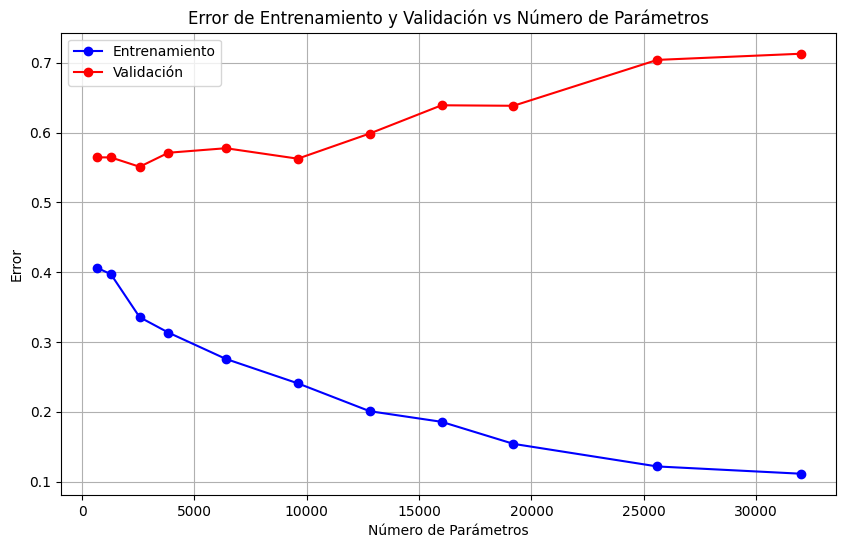

In [5]:
import matplotlib.pyplot as plt

# Graficar los errores de entrenamiento y validación vs número de parámetros
plt.figure(figsize=(10, 6))

# Graficar el error de entrenamiento
plt.plot(num_params_list, [train[-1] for train in train_losses], marker='o', label='Entrenamiento', color='blue')

# Graficar el error de validación
plt.plot(num_params_list, [val[-1] for val in val_losses], marker='o', label='Validación', color='red')

# Etiquetas y título
plt.xlabel('Número de Parámetros')
plt.ylabel('Error')
plt.title('Error de Entrenamiento y Validación vs Número de Parámetros')

# Agregar leyenda
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()



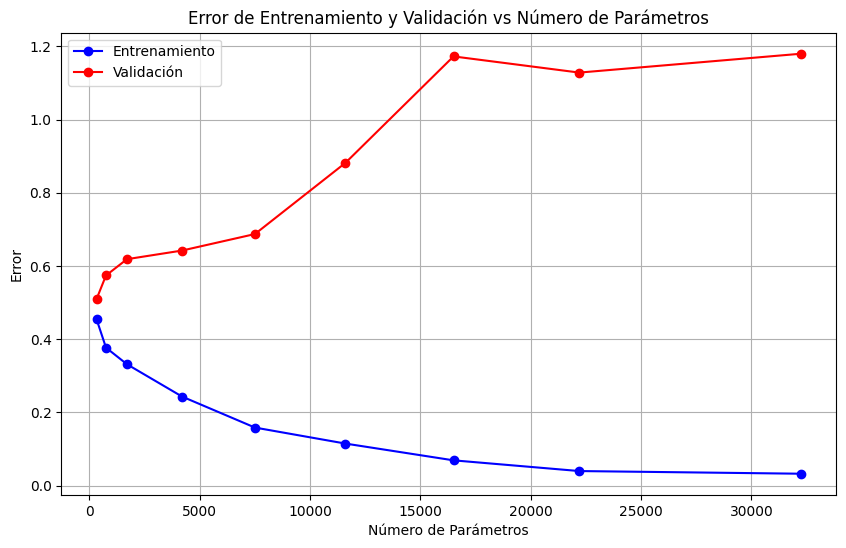

In [7]:
import matplotlib.pyplot as plt

# Graficar los errores de entrenamiento y validación vs número de parámetros
plt.figure(figsize=(10, 6))

# Graficar el error de entrenamiento
plt.plot(num_params_list, [train[-1] for train in train_losses], marker='o', label='Entrenamiento', color='blue')

# Graficar el error de validación
plt.plot(num_params_list, [val[-1] for val in val_losses], marker='o', label='Validación', color='red')

# Etiquetas y título
plt.xlabel('Número de Parámetros')
plt.ylabel('Error')
plt.title('Error de Entrenamiento y Validación vs Número de Parámetros')

# Agregar leyenda
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()